In [380]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint

import sympy as sp

import pandas as pd

import copy
import math

In [381]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

In [382]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

In [383]:
# UGV dynamics
params = dict(m=20.0, kv=300.0, bv=20.0,
              Iz=1.0, kw=50.0, bw=2.0)

def f(x, u, m=params['m'], kv=params['kv'], bv=params['bv'], Iz=params['Iz'], kw=params['kw'], bw=params['bw']):
    """
    UGV dynamics in continuous time for odeint.
    """
    v_cmd, w_cmd = u

    # Unpack state
    X, Y, theta, xdot, ydot, thetadot = x

    # Body-frame forward velocity
    v_body = np.cos(theta) * xdot + np.sin(theta) * ydot

    # Effective acceleration coefficients
    alpha_v = kv / m
    gamma_v = (kv + bv) / m
    alpha_w = kw / Iz
    gamma_w = (kw + bw) / Iz

    # Accelerations
    xddot = -gamma_v * v_body * np.cos(theta) + alpha_v * np.cos(theta) * v_cmd
    yddot = -gamma_v * v_body * np.sin(theta) + alpha_v * np.sin(theta) * v_cmd
    thetaddot = -gamma_w * thetadot + alpha_w * w_cmd

    # Collect derivatives
    return [
        xdot,       # dx/dt
        ydot,       # dy/dt
        thetadot,   # dtheta/dt
        xddot,      # d(xdot)/dt
        yddot,      # d(ydot)/dt
        thetaddot   # d(thetadot)/dt
    ]

In [384]:
#Measurements from ArUco (post-translation)
def h_aruco(x_vec, u_vec):
    # Extract state variables
    X = x_vec[0]
    Y = x_vec[1]
    theta = x_vec[2]
    xdot = x_vec[3]
    ydot = x_vec[4]
    thetadot = x_vec[5]

    # Extract control inputs
    v = u_vec[0]
    w = u_vec[1]

    #Add gaussian noise to measurements
    X_new = X + np.random.normal(0, 0.2)
    Y_new = Y + np.random.normal(0, 0.2)
    theta_new = theta + np.random.normal(0, 0.1)
    # Measurements
    y_vec = [X_new, Y_new, theta_new]  # position and heading

    # Return measurement
    return y_vec

In [385]:
#Measurements from ArUco (post-translation)
def h_imu(x_vec, u_vec):
    # Extract state variables
    X = x_vec[0]
    Y = x_vec[1]
    theta = x_vec[2]
    xdot = x_vec[3]
    ydot = x_vec[4]
    thetadot = x_vec[5]

    # Extract control inputs
    v = u_vec[0]
    w = u_vec[1]

    #Add gaussian noise to measurements
    thetadot_m = thetadot
    # Measurements
    y_vec = [thetadot]  # position and heading

    # Return measurement
    return y_vec

In [386]:
   #Measurements from ArUco (post-translation)
def h_vbody(x_vec, u_vec):
    # Extract state variables
    X = x_vec[0]
    Y = x_vec[1]
    theta = x_vec[2]
    xdot = x_vec[3]
    ydot = x_vec[4]
    thetadot = x_vec[5]

    # Extract control inputs
    v = u_vec[0]
    w = u_vec[1]

    #Add gaussian noise to measurements
    v_body = np.cos(theta) * xdot + np.sin(theta) * ydot
    thetadot_m = thetadot + np.random.normal(0, 0.1)
    # Measurements
    y_vec = [v_body]  # position and heading


    # Return measurement
    return y_vec


In [387]:
def h_all(x_vec, u_vec):
    # Extract state variables
    X = x_vec[0]
    Y = x_vec[1]
    theta = x_vec[2]
    xdot = x_vec[3]
    ydot = x_vec[4]
    thetadot = x_vec[5]

    # Extract control inputs
    v = u_vec[0]
    w = u_vec[1]

    aruco_pos = (10, 10)
    aruco_pos2 = (-5, -5)

    #Add gaussian noise to measurements
    v_body = np.cos(theta) * xdot + np.sin(theta) * ydot
    x_aruco = abs(aruco_pos[0] - X)
    y_aruco = abs(aruco_pos[1] - Y)
    euc_aruco = math.dist(aruco_pos, (X, Y))
    euc_aruco2 = math.dist(aruco_pos2, (X, Y))
    # Measurements
    if theta <=1.5 and theta>= 1.0:
      y_vec = [X, Y, v_body, thetadot, theta, euc_aruco, euc_aruco2]  # position and heading
    else:
      y_vec = [-1000, -1000, v_body, thetadot, theta, euc_aruco, euc_aruco2]  # position and heading


    # Return measurement
    return y_vec

In [388]:
#Simulator
state_names = ['X', 'Y', 'theta', 'xdot', 'ydot', 'thetadot']
input_names = ['v', 'w']
#measurement_names = ['X', 'Y', 'theta']
measurement_names = ['X', 'Y', 'v_body', 'thetadot', 'theta', 'euc_aruco', 'euc_aruco2']
#measurement_names = ['vbody']
dt = 0.1

tsim = np.arange(0, 8.0, step=dt)


simulator = pybounds.Simulator(f, h_all, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)
NA = np.zeros_like(tsim)
setpoint = {'X': tsim,  # move along X axis at 1 m/s
            'Y': np.sin(tsim),  # oscillate in Y
            'theta': NA,
            'xdot': NA,
            'ydot': NA,
            'thetadot': NA,
           }
simulator.update_dict(setpoint, name='setpoint')

cost_x = (simulator.model.x['X'] - simulator.model.tvp['X_set']) ** 2
cost_z = (simulator.model.x['Y'] - simulator.model.tvp['Y_set']) ** 2

cost = cost_x + cost_z

simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(v=1e-4, w=1e-4)
simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
simulator.mpc.bounds['upper', '_u', 'w'] = 1.0
simulator.mpc.bounds['lower', '_u', 'w'] = -1.0
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=[0, 0, 0.7854, 0, 0, 0], u=None, mpc=True, return_full_output=True)

In [389]:
x_sim

{'X': array([0.        , 0.05050232, 0.14288808, 0.24527985, 0.35091654,
        0.45630688, 0.56078079, 0.66501751, 0.76982238, 0.87585847,
        0.98358087, 1.08434938, 1.18752305, 1.27686122, 1.34926526,
        1.42855911, 1.53717912, 1.65209922, 1.75851533, 1.86132446,
        1.96933351, 2.07810164, 2.18404525, 2.28934291, 2.39405168,
        2.49769619, 2.60020057, 2.70170518, 2.80236714, 2.90235566,
        3.00187784, 3.10112885, 3.20029649, 3.29955318, 3.39902914,
        3.4988019 , 3.59888467, 3.69921672, 3.79967945, 3.90013757,
        4.00048107, 4.10065031, 4.20064162, 4.30049732, 4.40028505,
        4.50007373, 4.59991459, 4.69983195, 4.79982412, 4.89987121,
        4.99994573, 5.10002199, 5.20008214, 5.30011802, 5.40012988,
        5.50012317, 5.60010518, 5.70008247, 5.80005979, 5.90004057,
        6.00002671, 6.10001725, 6.20000941, 6.30000127, 6.3999938 ,
        6.49999074, 6.59999657, 6.70001368, 6.80004052, 6.90007163,
        7.00009951, 7.1001123 , 7.20064812,

Text(0, 0.5, 'y pos')

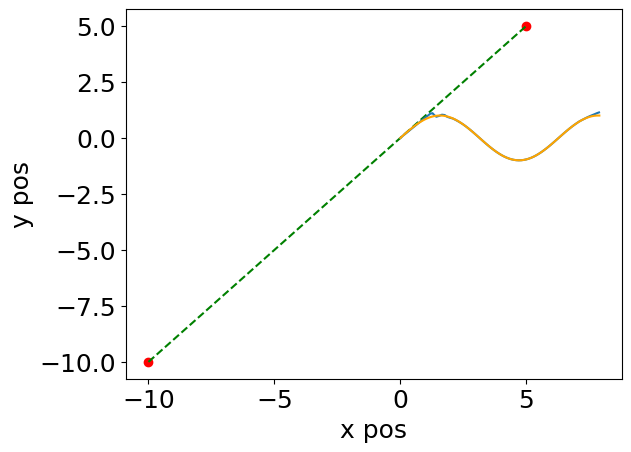

In [390]:
#Plot x,y trajectory
fig = plt.figure()
ax = fig.add_subplot(111)



#Plot point at 10, 10
ax.plot(-10, -10, 'ro')
ax.plot(5, 5, 'ro')
#Plot y=x line dashed
ax.plot(np.linspace(-10, 5), np.linspace(-10, 5), '--', color='green')
ax.plot(x_sim['X'], x_sim['Y'])
ax.plot(setpoint['X'], setpoint['Y'], color='orange')
ax.set_xlabel('x pos')
ax.set_ylabel('y pos')

Text(0, 0.5, 'x and y vel')

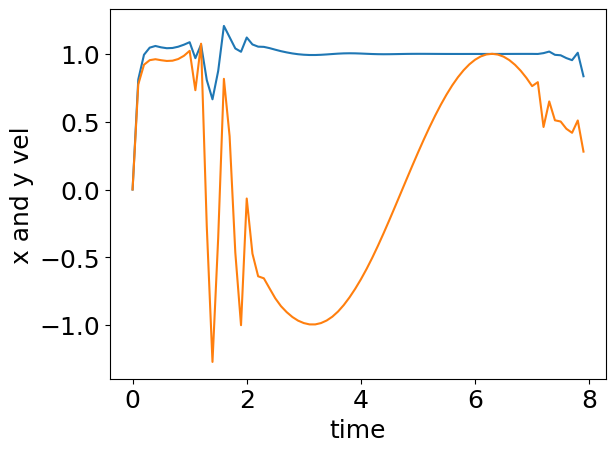

In [391]:
#Plot Velocities
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_sim, x_sim['xdot'])
ax.plot(t_sim, x_sim['ydot'])

ax.set_xlabel('time')
ax.set_ylabel('x and y vel')

Text(0, 0.5, 'Forward vel in body frame')

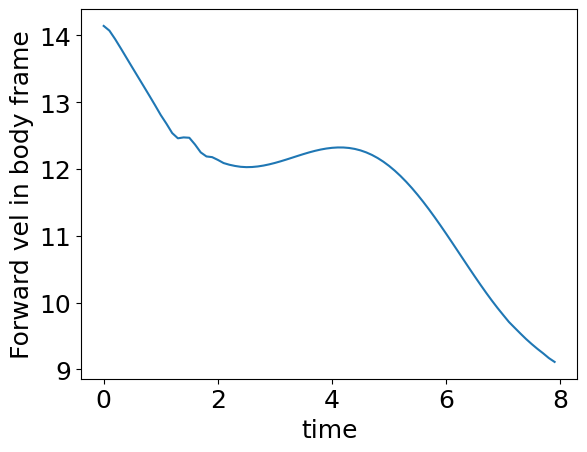

In [392]:
#Plot Angular Velocity
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(t_sim, y_sim['euc_aruco'])

ax.set_xlabel('time')
ax.set_ylabel('Forward vel in body frame')

# Define noise characteristics

Choose noise properties for each sensor, and apply the noise to each measurement stream

In [393]:
measurement_noise_stds = {'X': 0.5,
                          'Y': 0.5,
                          'theta': 0.25,
                          'thetadot': 0.25,
                          'v_body': 0.23,
                          'euc_aruco': 0.5,
                          'euc_aruco2': 0.5
                         }

# Observability analysis

In [394]:
w = 6  # window size, set to None to use entire time-series as one window

In [395]:
# Construct O in sliding windows
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [396]:
n_window = len(O_sliding)
print(n_window, 'windows')

75 windows


In [397]:
O_sliding[1]

,,X,Y,theta,xdot,ydot,thetadot
sensor,time_step,,,,,,
X,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Y,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
v_body,0,0.000000e+00,0.000000e+00,6.173781e-02,7.599011e-01,6.500387e-01,0.000000e+00
thetadot,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
theta,0,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
euc_aruco,0,-7.070593e-01,-7.071543e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
euc_aruco2,0,7.072004e-01,7.070132e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
X,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Y,1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [398]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}
print(measurement_noise_vars)

{'X': 0.25, 'Y': 0.25, 'theta': 0.0625, 'thetadot': 0.0625, 'v_body': 0.0529, 'euc_aruco': 0.25, 'euc_aruco2': 0.25}


In [399]:
# Compute the Fisher information & Chernoff inverse
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [400]:
# Get the Fisher information, inverse, and R matrix
F, F_inv, R = FO.get_fisher_information()
F_inv

,X,Y,theta,xdot,ydot,thetadot
X,5432.678322,-5435.531561,-0.003856,5.654207,-5.869730,-0.000068
Y,-5435.531561,5438.433354,0.003731,-5.560052,5.768638,0.000066
theta,-0.003856,0.003731,0.010432,0.000306,-0.000316,-0.001000
xdot,5.654207,-5.560052,0.000306,1.978601,-1.965777,-0.000274
ydot,-5.869730,5.768638,-0.000316,-1.965777,2.055105,0.000274
thetadot,-0.000068,0.000066,-0.001000,-0.000274,0.000274,0.062479


In [401]:
# Choose sensors to use from O
o_sensors = ['thetadot', 'v_body','euc_aruco' ,'euc_aruco2']

# Chose states to use from O
o_states = state_names

# Choose time-steps to use from O
window_size = 6 # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [402]:
# Compute the Fisher information & inverse for each window and store the minimum error variance
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

# If you want to manually inspect one of the fisher info matrices:
# SFO.FO[1].O

In [403]:
# Pull out minimum error variance, 'time' column is the time vector shifted forward by w/2 and 'time_initial' is the original time
EV_aligned = SFO.get_minimum_error_variance()

In [404]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


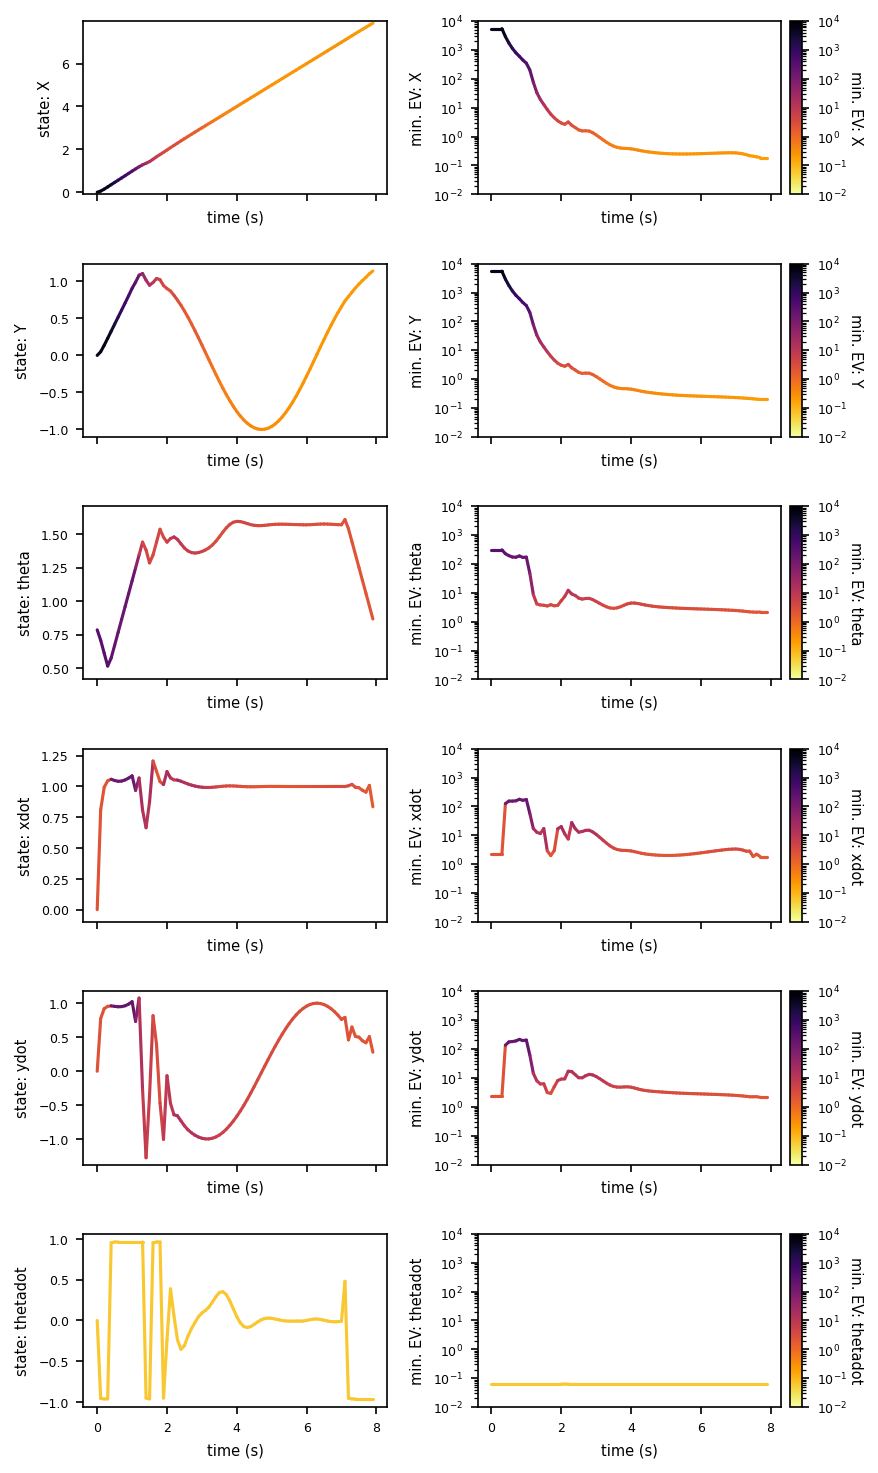

In [405]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)